In [8]:
import numpy as np
import pandas as pd
from pylab import rcParams
%pylab inline
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cityblock
from fastdtw import fastdtw
from operator import itemgetter
from scipy.stats import kurtosis, skew
import csv

Populating the interactive namespace from numpy and matplotlib


In [9]:
rcParams['figure.figsize'] = 16,8

## Dataset: IBM stock values from 1962 to 2018

https://finance.yahoo.com/quote/ibm/history/

Il dataset utilizzato è stato scaricato da Yahoo Finance e contiene dati giornalieri relativi alle azioni della International Business Machines Corporation (IBM) da gennaio 1962 ad aprile 2018. Esso presenta 14168 record e 7 attributi, dei quali il primo è la data dell’osservazione, mentre gli altri 6 sono di tipo numerico, in particolare: Open, High, Low, Close, Adj e Volume.
La serie utilizzata in questa relazione è quella dei prezzi d’apertura (Open).

In [3]:
series = pd.Series.from_csv("dataset/ibm_daily_1962-2018.csv", sep = '\t', header = 0)
series.describe()

/Users/francesco/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


count    14168.000000
mean        57.438904
std         56.427873
min          4.080000
25%         15.967187
50%         27.843750
75%         93.757500
max        215.380005
Name: Open, dtype: float64

### Data Visualization

Ad una prima analisi si può subito osservare come i valori della serie non abbiano una distribuzione normale, essendo prezzi bassi, in particolare compresi tra 0 e 50, molto più frequenti rispetto a prezzi alti.

#### Line Plot

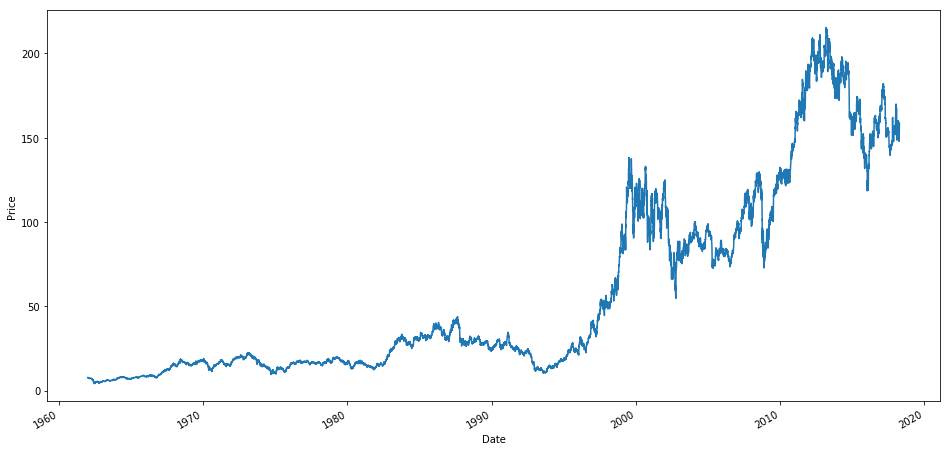

In [10]:
xlabel("Year")
ylabel("Price")
series.plot()

#### Density Plot

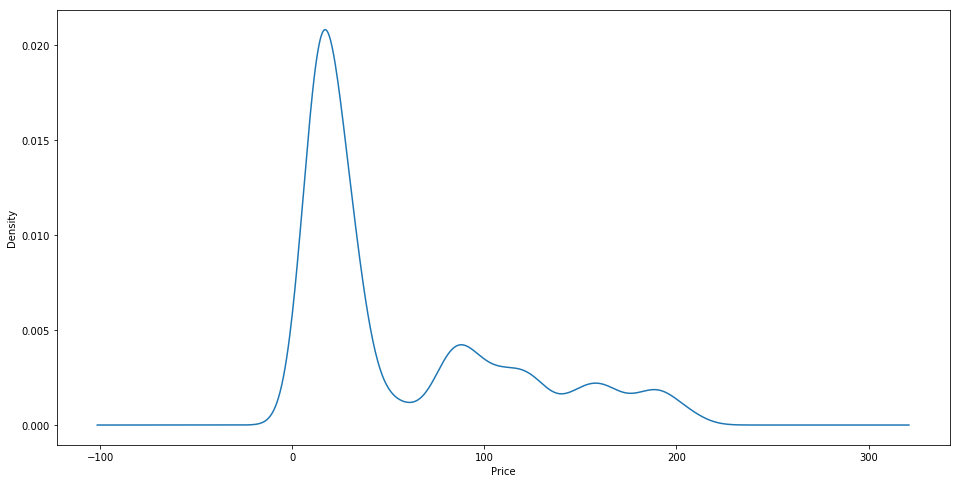

In [11]:
xlabel("Price")
series.plot(kind='kde')
pyplot.show()

#### Autocorrelation

Si nota la presenza di una forte autocorrelazione nel breve periodo, che tende a diminuire con all’aumentare del ritardo considerato.




In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)
axis('auto')
pyplot.show()

### Yearly Line Plot

Per prima cosa è stato eliminato l’anno 2018 in quanto (a Maggio 2018) ancora in corso e quindi avente 8 mesi di missing values. In secondo luogo la serie storica è stata divisa nelle 56 serie annuali. Ogni anno ha un numero diverso di osservazioni in quanto le festività, nelle quali la borsa è chiusa, cadono di anno in anno in giorni differenti.

In [12]:
series = series["1962-01-02":"2017-12-29"] # Rimuovo il 2018

In [13]:
groups = series.groupby(pd.Grouper(freq='A'))
years = []  
yearly_series = []
yearly_list = []
for name, group in groups:
    years.append(name.year) # Lista contenente gli anni
    yearly_series.append(pd.Series(group)) # Lista contenente serie pandas per ogni anno
    yearly_list.append(list(group.values)) # Lista contenente liste per ogni anno

Text(0, 0.5, 'Price')

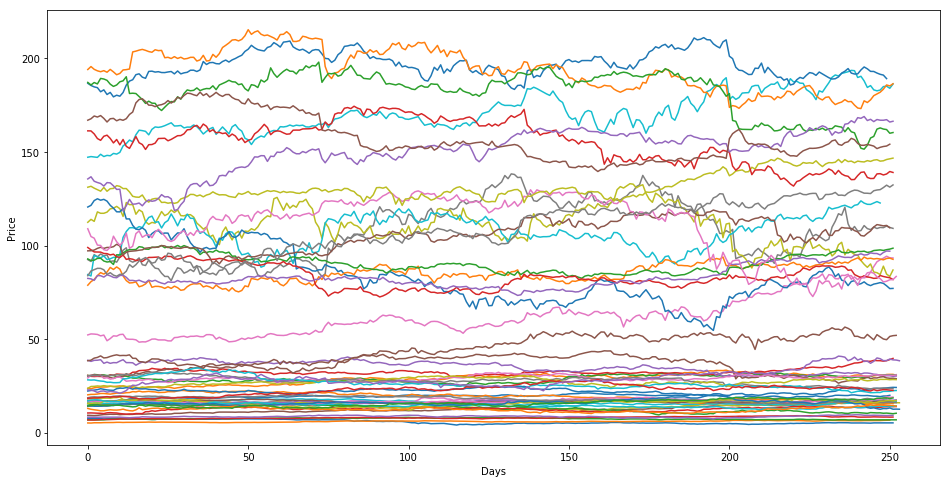

In [14]:
for i in range(len(yearly_list)):
    plt.plot(yearly_list[i])
xlabel("Days")
ylabel("Price")

### Yearly Transformations

Le serie annuali sono state standardizzate (z-score), permettendo di allinearle, riducendo le differenze di offset e di scala.

#### Normalization

In [15]:
yearly_list_norm = []
for name, group in groups:
    group_values = list(group.values)
    scaling_values = (group_values - mean(group_values))/std(group_values)
    yearly_list_norm.append(scaling_values)

Text(0, 0.5, 'Price - normalized')

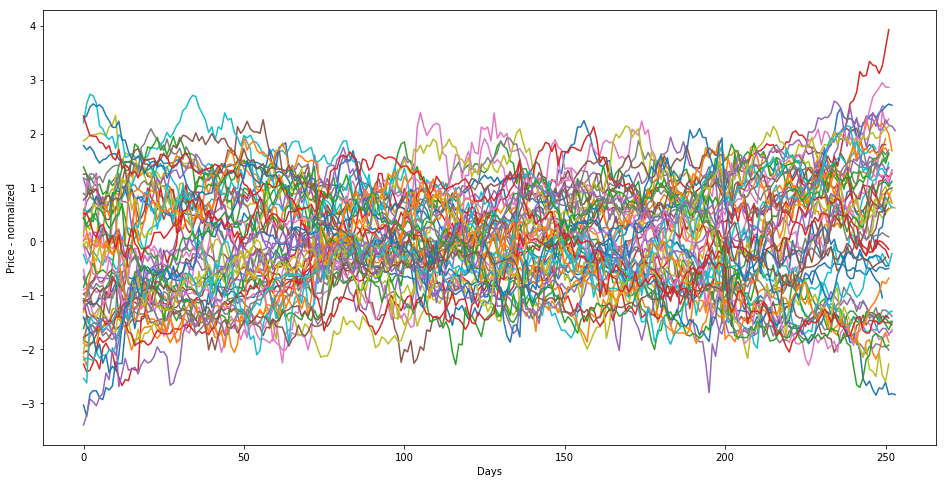

In [52]:
for i in range(len(yearly_list_norm)):
    plt.plot(yearly_list_norm[i])
xlabel("Days")
ylabel("Price - normalized")

#### Noise (smoothing)

E’ applicato un noise smoothing attraverso la media mobile su dieci giorni consecutivi; questo valore è stato posto a 10 poiché la media mobile a 10 periodi è molto utilizzata in ambito finanziario in quanto indicativa del rumore del mercato, ossia di quelle oscillazioni minori del prezzo che non vanno ad intaccare la tendenza di fondo in corso.

In [53]:
yearly_list_smooth = []
for name, group in groups:
    group_values = list(group.values)
    scaling_values = (group_values - mean(group_values))/std(group_values)
    scaling_series = pd.Series(scaling_values) #trasformo in serie per calcolare la rolling mean
    shift_series = scaling_series.rolling(window = 10).mean()
    yearly_list_smooth.append(list(shift_series))

Text(0, 0.5, 'Price - normalized')

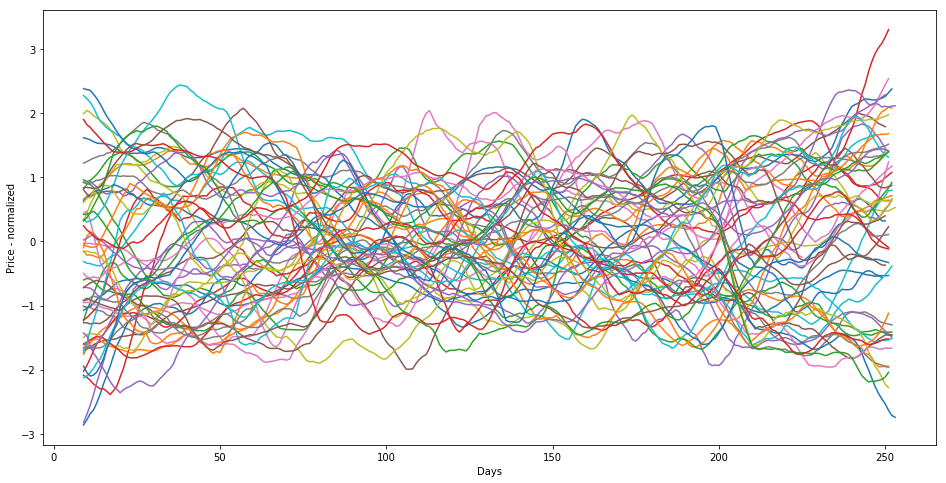

In [54]:
for i in range(len(yearly_list_smooth)):
    plt.plot(yearly_list_smooth[i])
xlabel("Days")
ylabel("Price - normalized")

In [55]:
#rimozione missing values generati dallo smoothing con media mobile
yearly_series_smooth = []
for i in range(len(yearly_list_smooth)):
    yearly_series_smooth.append(pd.Series(yearly_list_smooth[i]))
    yearly_series_smooth[i] = pd.Series.dropna(yearly_series_smooth[i])

## DTW

https://www.aaai.org/Papers/Workshops/1994/WS-94-03/WS94-03-031.pdf

https://pypi.org/project/fastdtw/

In generale, il Dynamic Time Warping è una distanza che permette di trovare una corrispondenza ottima tra due sequenze, attraverso una distorsione non lineare rispetto alla variabile indipendente. Il DTW si è rivelato particolarmente utile per queste serie temporali in quanto, al contrario della distanza euclidea, può essere applicato anche su serie di lunghezza differente, e inoltre è risultato efficace nel trattare sequenze con pattern simili ma che variano nel tempo, per i quali la semplice espansione o compressione lineare non avrebbe portato a risultati soddisfacenti. Per poter procedere al clustering è stato calcolato il DTW sulle serie annuali, confrontando ciascuna con tutte le altre, e salvando le rispettive distanze in una matrice 56x56.

In [56]:
%%time
# CAUTION !!! CAN BE VERY SLOW !!!
# month_list = mm_small.keys()
# Compute upper half of matrix
dd1 = [ [ (fastdtw(list(yearly_series_smooth[x]), list(yearly_series_smooth[y]), dist = cityblock)[0] \
           if y > x else -1)  \
         for y in range(len(years)) ] 
       for x in range(len(years)) ]
# Copy values also to the lower half, exployting symmetry of the distance function
dd2 = [ [ (dd1[x][y] if y > x else dd1[y][x])  for y in range(len(years)) ] for x in range(len(years)) ]
# Finally, the diagonal
for i in range(len(years)):
    dd2[i][i] = 0.0

CPU times: user 1min 41s, sys: 553 ms, total: 1min 41s
Wall time: 1min 45s


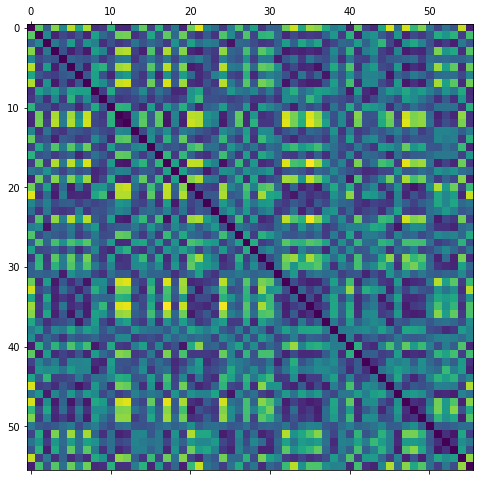

In [57]:
matshow(dd2, interpolation=None, aspect='auto')

In [60]:
# Esporto la matrice in csv per non doverla ricalcolare ogni volta

with open("distance_matrices/dd2_smooth_dtw.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(dd2)

## CDM

https://link.springer.com/article/10.1007/s10618-006-0049-3

L’idea alla base della CDM è di utilizzare la compressione dei dati per classificare le sequenze su alfabeti finiti. Date due stringhe x e y, si definisce CDM come:
\begin{equation*}
CDM(x,y) = \frac{C(xy)}{C(x)+C(y)}
\end{equation*}
Dove C(x) è la dimensione compressa di x. La CDM si avvicina ad 1 quando x e y non sono correlate, mentre più CDM diminuisce, più x e y sono correlate.
Per poter utilizzare questa misura, le serie numeriche sono state pertanto discretizzate attraverso un alfabeto di 10 simboli.

In [62]:
from utils import CDM

In [63]:
%%time
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

# Compute upper half of matrix
dd1 = [ [ (CDM((''.join(array(pd.cut(list(yearly_series_smooth[x]),len(alphabet),labels=alphabet)))).encode(),(''.join(array(pd.cut(list(yearly_series_smooth[y]),len(alphabet),labels=alphabet)))).encode()) \
           if y > x else -1)  \
         for y in range(len(years)) ] 
       for x in range(len(years)) ]
# Copy values also to the lower half, exployting symmetry of the distance function
dd2 = [ [ (dd1[x][y] if y > x else dd1[y][x])  for y in range(len(years)) ] for x in range(len(years)) ]
# Finally, the diagonal
for i in range(len(years)):
    dd2[i][i] = 0.0

# Copy values also to the lower half, exployting symmetry of the distance function
dd2 = [ [ (dd1[x][y] if y > x else dd1[y][x])  for y in range(len(years)) ] for x in range(len(years)) ]
# Finally, the diagonal
for i in range(len(years)):
    dd2[i][i] = 0.0

CPU times: user 2.82 s, sys: 22.3 ms, total: 2.84 s
Wall time: 2.9 s


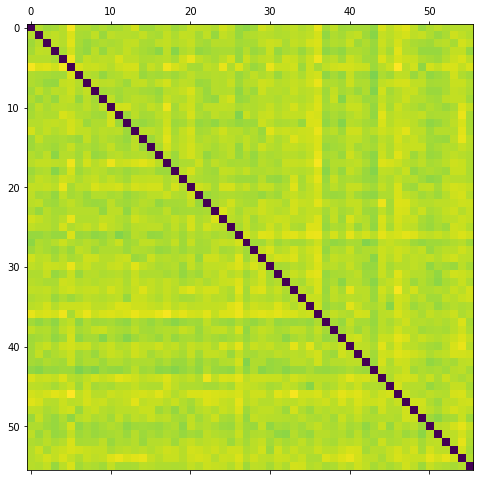

In [64]:
matshow(dd2, interpolation=None, aspect='auto')

In [65]:
# Esporto la matrice in csv per non doverla ricalcolare ogni volta
    
with open("distance_matrices/dd2_smooth_cdm.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(dd2)

## Structural Distances

L’obiettivo di questo metodo è quello estrarre delle significative features globali dalle serie temporali, creare un vettore e quindi utilizzarlo per misurare la similarità/dissimilarità. Le features qui utilizzate sono: media, deviazione standard, asimmetria (skewness) e curtosi.

In [66]:
feat = []
for i in range(len(yearly_series_smooth)):
    feat.append([mean(np.array(yearly_series_smooth[i])), 
                 std(np.array(yearly_series_smooth[i])), 
                 kurtosis(np.array(yearly_series_smooth[i])),
                 mean(np.array(yearly_series_smooth[i])[1:]-np.array(yearly_series_smooth[i])[:-1]),
                 skew(np.array(yearly_series_smooth[i])[1:]-np.array(yearly_series_smooth[i])[:-1]),
                 kurtosis(np.array(yearly_series_smooth[i])[1:]-np.array(yearly_series_smooth[i])[:-1])])

In [67]:
#normalizzo
norm_feat = transpose([ (attr-mean(attr))/std(attr)  for attr in transpose(feat) ])

In [70]:
# Esporto la matrice in csv per non doverla ricalcolare ogni volta

with open("distance_matrices/norm_feat.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(norm_feat)